In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.metrics import mean_squared_error

In [2]:
GOOGL = pd.read_csv('GOOGL.csv')

### Model 2. Moving Average
Moving Average is a very simple model for Time Series modelling.

$MA = \frac{A_1 + A_2 + \cdots + A_n}{n}$

where:

$A = $ Average in period $n$

$n = $ Number of time periods 

In [3]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

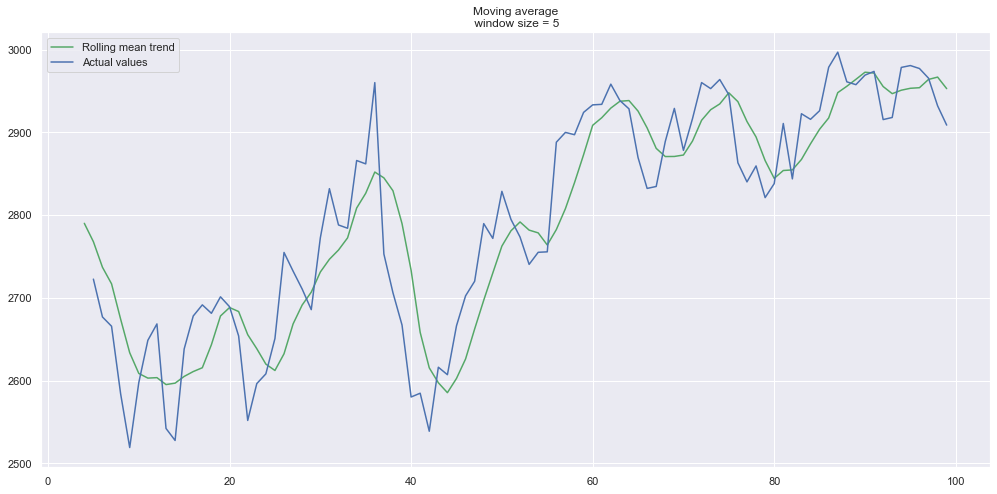

In [4]:
#Smooth by the previous 5 days (by week)
plot_moving_average(GOOGL['4. close'], 5)

In [94]:
GOOGL['4. close'].rolling(window=5).mean().isnull().sum()

4

In [64]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=5).mean()[-96:], 
    GOOGL['4. close'][-96:])

3223.744743708334

Moving average smooths out price trends by filtering out "noise" from random short-term price fluctuations. From the above graph we can see that moving the average on a weekly basis does smoothen out the price values, but still follows the general shape of the actual prices, leading us to believe that this is a good model. The MSE of this model is also 3223.7

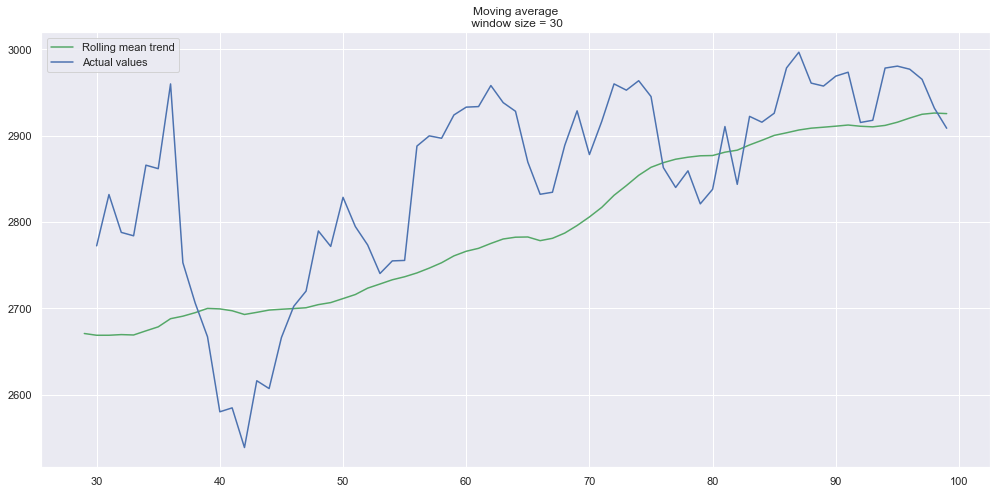

In [6]:
#Smooth by the previous month (30 days)
plot_moving_average(GOOGL['4. close'], 30)

In [93]:
GOOGL['4. close'].rolling(window=30).mean().isnull().sum()

29

In [78]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=30).mean()[-71:], 
    GOOGL['4. close'][-71:])

9822.485420777784

From the graph above, we can see that moving the average on a monthly basis smoothens out the actual price values too much, such that the model does not follow the shape of the actual price values. The MSE of this model is also 9822.5, about three times the MSE of Weekly Moving Average, as such we believe this is not a good model to use

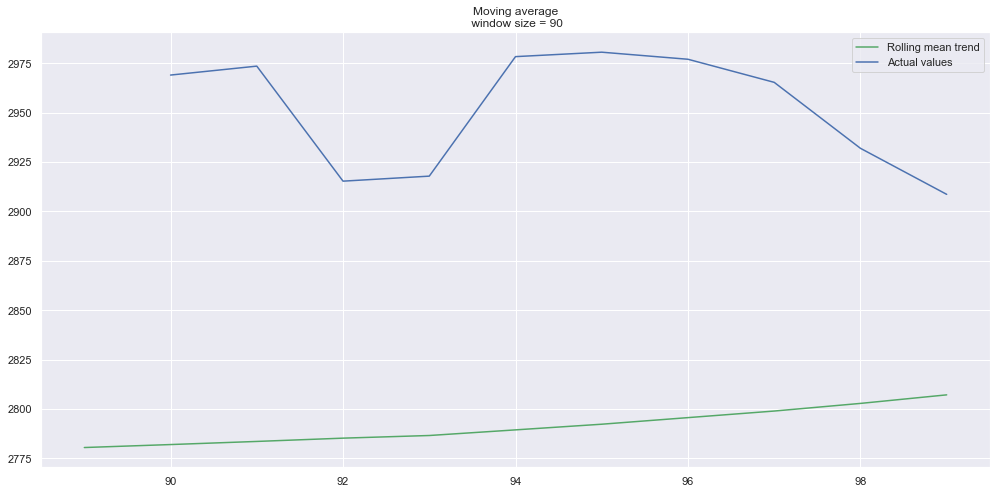

In [22]:
#Smooth by previous quarter (90 days)
plot_moving_average(GOOGL['4. close'], 90)

In [91]:
GOOGL['4. close'].rolling(window=90).mean().isnull().sum()

89

In [92]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=90).mean()[-11:], 
    GOOGL['4. close'][-11:])

26851.471962276046

From the above, we can see that moving the average by the previous quarter smoothens out the price values far too much, such that the model is very far from the actual price values. The MSE is 26851.5 which is nearly nine times the value of the MSE weekly average, as such we believe this is a terrible model and should not be used

### Model 3. Exponential Smoothing

$y = \alpha x_t + (1 - \alpha)y_{t-1}, t > 0$

In [44]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [45]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

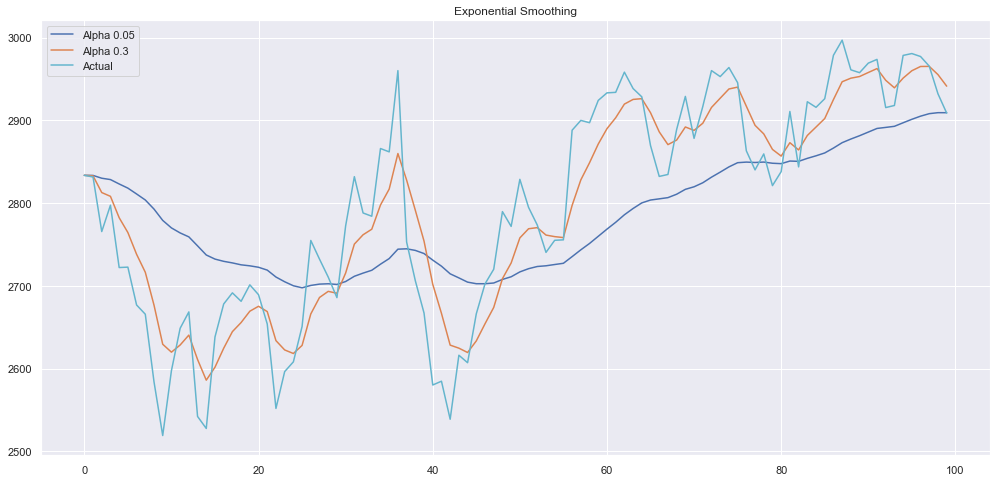

In [46]:
plot_exponential_smoothing(GOOGL['4. close'], [0.05, 0.3])

In [96]:
mean_squared_error(
    exponential_smoothing(GOOGL['4. close'], 0.05)[-100:], 
    GOOGL['4. close'][-100:])

10264.82601473811

In [97]:
mean_squared_error(
    exponential_smoothing(GOOGL['4. close'], 0.3)[-100:], 
    GOOGL['4. close'][-100:])

2271.7548753566252

Like moving average, exponential smoothing also filters out the noise from short term fluctuations. However exponential smoothing assigns exponentially decreasing weights as a data point gets older, this means that an older data point has less weight to the model than the newest data point. The two alpha parameters 0.05 and 0.3 assigns how important the current data point is for the model. </p>

We also see that the low alpha value (0.05) smoothens out the curve too much, and does not follow the shape of the actual price values well. the 0.05 alpha also give us an MSE of 10264.6, which is very high. On the other hand the higher alpha value (0.3) gives us a graph that follows the actual price a lot better. The 0.3 alpha also gives an MSE of 2271.8 which is actually lower than the MSE of the weekly moving price (3223.7). the 0.3 alpha model is more smooth, so the short-term noise is successfully filtered out but still follows the actual price well, as such the alpha 0.3 exponential smoothing model is a good model to use

### Model 4. Double Exponential Smoothing

Double Exponential Smoothing is used when there is a trend in the time series. In that case, . 

$y = \alpha x_t + (1 - \alpha)(y_{t-1} + b_{t-1})$

$b_t = \beta (y_t - y_{t-1}) + (1 - \beta)b_{t-1}$

In [55]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result



In [56]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

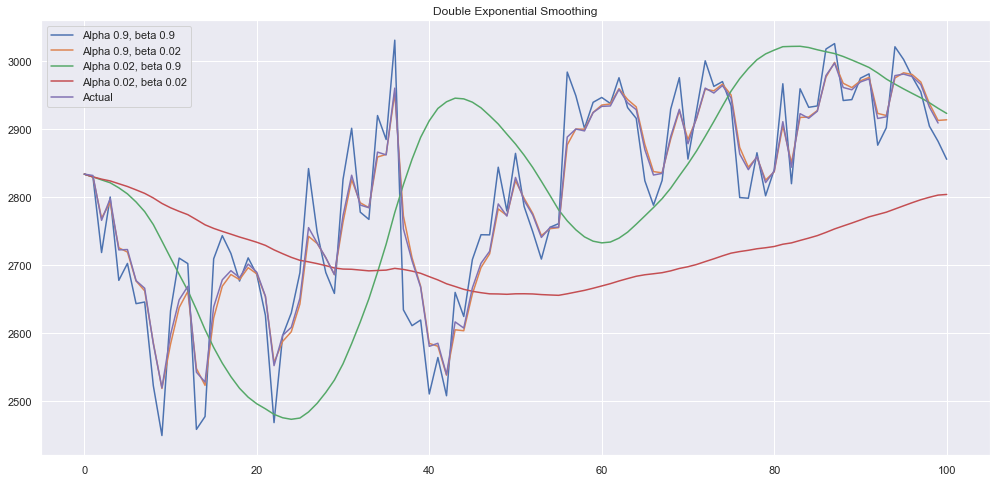

In [57]:
plot_double_exponential_smoothing(GOOGL['4. close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [98]:
mean_squared_error(
    double_exponential_smoothing(GOOGL['4. close'], 0.9, 0.9)[-100:], 
    GOOGL['4. close'][-100:])

8290.152134606713

In [99]:
mean_squared_error(
    double_exponential_smoothing(GOOGL['4. close'], 0.9, 0.02)[-100:], 
    GOOGL['4. close'][-100:])

2286.2085324748255

In [100]:
mean_squared_error(
    double_exponential_smoothing(GOOGL['4. close'], 0.02, 0.9)[-100:], 
    GOOGL['4. close'][-100:])

21465.79440265126

In [101]:
mean_squared_error(
    double_exponential_smoothing(GOOGL['4. close'], 0.02, 0.02)[-100:], 
    GOOGL['4. close'][-100:])

24617.954118046888

From the above we can see that from the different combinations of alpha and beta, we are able to get four graphs. The graphs with 0.02 alpha give terrible graphs that do not follow the actual price values at all. The MSE for the alpha 0.02 beta 0.9 graph is 21465.8 and the MSE for the alpha 0.02 beta 0.02 is 24618.0, therefore from the graph and MSE values these two models should not be used. </p>

On the other hand the two models with alpha 0.9 are quite good. The model with alpha 0.9 beta 0.02 follows the actual prices extremely closely, and gives an MSE of 2286.2. However we believe that we should not use this model as the model follows the actual prices TOO closely and as such the filtering of short-term noise is not actually succesfull. </p>

For the alpha 0.9 beta 0.9 model, the model follows the actual price well but not as close as the alpha 0.9 beta 0.02, its MSE is also 8290.1. As such we believe that this model could be used as it does not follow the actual prices too closely and as such noise filtering is achieved although at the cost of a higher MSE.